In [1]:
# limit the thread used by numpy for better parallelization
import os

os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"

In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt
# import logging

# sys.path.append("..")
from Triangle.Constants import *
from Triangle.FFTTools import *
from Triangle.Noise import *
from Triangle.Orbit import *
from Triangle.Data import *
from Triangle.Interferometer import *
from Triangle.TDI import *
from Triangle.Glitch import *
from Triangle.GW import *

try:
    import cupy as xp
    # print("Has Cupy")
    # HAS_GPU = True
except ImportError:
    import numpy as xp
    # print("No Cupy")
    # HAS_GPU = False

# import healpy as hlp

# Uncomment this if LaTeX is installed for better visualization
# import matplotlib
# matplotlib.rcParams['text.usetex'] = True
# matplotlib.rcParams['font.family'] = 'serif'

# logging.basicConfig()
# logging.getLogger().setLevel(logging.INFO)

# import multiprocessing

# if __name__ == "__main__":
#     multiprocessing.set_start_method("fork")
# print("number of cpus =", multiprocessing.cpu_count())
# pool = multiprocessing.Pool(processes=multiprocessing.cpu_count())
# pool = None

no cupy 


PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


## General implementation 

In [3]:
# set the TCB times of resulting TDI responses
# t_start = 10 * DAY 
t_start = 0 
Tobs = 15 * DAY
dt = 5.
tcb_times = np.arange(int(Tobs / dt)) * dt + t_start

# orbit model
orbit = Orbit(OrbitDir="../OrbitData/MicroSateOrbitEclipticTCB")

tcb_times[0] / DAY, tcb_times[-1] / DAY 

(0.0, 14.99994212962963)

In [4]:
# approximant = "IMRPhenomXPHM"
approximant = "SEOBNRv4_opt"

mbhb_waveform_generator = MBHB_Injection(approx_method=approximant, buffer=True)

mbhb_response_generator = GeneralTDIResponse(
    orbit=orbit,
    Pstring=GeneralTDIResponse.X2_strings,
    tcb_times=tcb_times.copy(),
    use_gpu=False,
    drop_points=int(1000 / dt),
    linear_interp=False,
    return_eta=False, 
)

In [5]:
MBHB_params = {
    "chirp_mass": 100000.0,
    "mass_ratio": 0.3640815267051051,
    "spin_1z": 0.7899406190510447,
    "spin_2z": 0.015424596359292053,
    "coalescence_time": tcb_times[-1] / DAY - 1.,
    "coalescence_phase": 3.2535342675592966,
    "luminosity_distance": 106039.10941463517,
    "inclination": 1.4495086550199021,
    "longitude": 3.032776598141215,
    "latitude": -1.1817968279048852,
    "psi": 0.2409146690555858,
}

In [6]:
for _ in tqdm(range(10)):
    X2_general = mbhb_response_generator(parameters=MBHB_params, waveform_generator=mbhb_waveform_generator)
X2_general.shape 

100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


(259200,)

In [7]:
t_end_detector = SSBTimetoDetectorTime(time_ssb=mbhb_waveform_generator.tend, orbit=orbit, longitude=MBHB_params["longitude"], latitude=MBHB_params["latitude"])
remove_idx = np.where(tcb_times > t_end_detector - MBHB_params["chirp_mass"] / 1e6)[0]
X2_general[remove_idx] *= 0. 

Text(0, 0.5, 'TDI-X2')

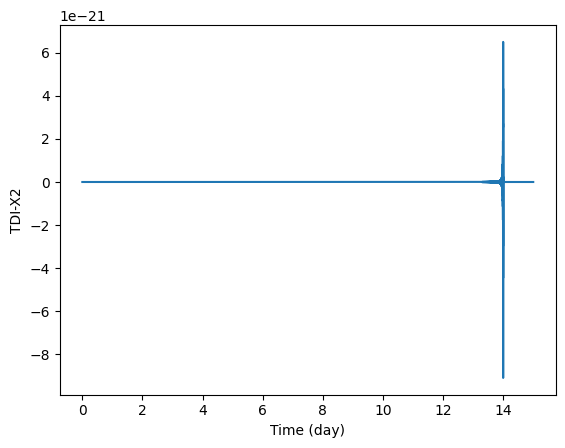

In [8]:
plt.plot(tcb_times / DAY, X2_general)
plt.xlabel("Time (day)")
plt.ylabel("TDI-X2")
# plt.ylim(-1e-23, 1e-23)
# plt.xlim(MBHB_params["coalescence_time"] - 0.02, MBHB_params["coalescence_time"] + 0.01)
# plt.xlim(9, 11)
# plt.xlim(24, 25.2)

## Faster implementation 

In [9]:
slice_idx = np.where((tcb_times>10*DAY)&(tcb_times<15*DAY))[0]
tcb_times_slice = tcb_times[slice_idx]

X2_general = X2_general[slice_idx]

mbhb_mich_generator = FastMichelsonTDIResponse(
    orbit=orbit, 
    tcb_times=tcb_times_slice.copy(), 
    use_gpu=False, 
    drop_points=int(1000./dt), 
    # interp_method="Spline5", 
    # interp_method="Spline3",
    # interp_method="Akima",
    interp_method="linear",
)

In [10]:
for _ in tqdm(range(10)):
    X2_fastmich, _, _ = mbhb_mich_generator(parameters=MBHB_params, waveform_generator=mbhb_waveform_generator, optimal_combination=False, complex_waveform=True)
X2_fastmich.shape 

100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


(86399,)

Text(0, 0.5, 'TDI-X2')

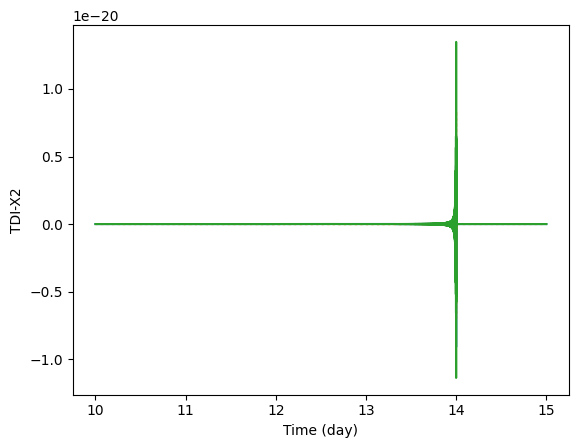

In [11]:
plt.plot(tcb_times_slice / DAY, X2_general)
plt.plot(tcb_times_slice / DAY, X2_fastmich, linestyle=":")
plt.plot(tcb_times_slice / DAY, X2_general - X2_fastmich)
plt.xlabel("Time (day)")
plt.ylabel("TDI-X2")
# plt.ylim(-1e-23, 1e-23)
# plt.xlim(MBHB_params["coalescence_time"] - 0.05, MBHB_params["coalescence_time"] + 0.05)
# plt.xlim(0, 1)

(1e-05, 1)

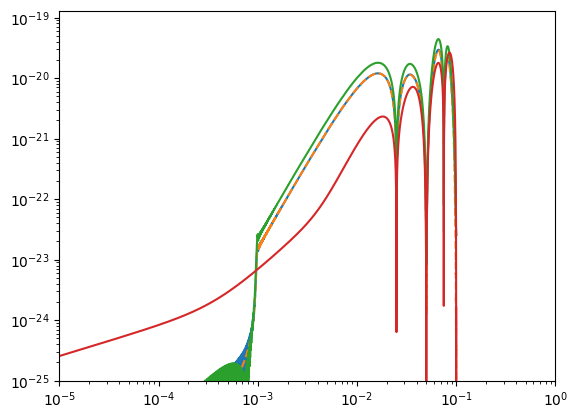

In [12]:
ff, xf = FFT_window(X2_general, 1./dt)
plt.loglog(ff, np.abs(xf) * 2. * ff)

ff, xf1 = FFT_window(X2_fastmich, 1./dt)
plt.loglog(ff, np.abs(xf1) * 2. * ff, linestyle="--")

plt.loglog(ff, np.abs(xf - xf1) * 2. * ff)

PSDfunc = TDIPSDs() 
plt.loglog(ff, np.sqrt(PSDfunc.PSD_X2(ff) * ff))

plt.ylim(1e-25,)
plt.xlim(1e-5, 1)

## Optimize over $\varphi_c$

In [13]:
def residual_SNR(wave1, wave2, dt): 
    if len(wave1) != len(wave2): 
        raise ValueError("data lengths mismatch.")
    win_args = dict(window_type="tukey", window_args_dict=dict(alpha=0.05))
    ff, xf = FFT_window(wave1, 1./dt, **win_args)
    _, xf1 = FFT_window(wave2, 1./dt, **win_args)
    df = ff[1] - ff[0]
    mask = np.ones_like(ff, dtype=bool)
    for i in range(1, 40):
        mask_idx = np.where(np.abs(ff - i * 0.025)<3e-4 * i)[0]
        mask[mask_idx] = False 
    xf = xf[mask]
    xf1 = xf1[mask]
    PSDfunc = TDIPSDs()
    PSDdata = PSDfunc.PSD_X2(ff[mask])
    return np.sqrt(np.sum(np.abs(xf - xf1) ** 2 / PSDdata * 4. * df)) 

In [14]:
Ntest = 100
test_phis = np.linspace(0, TWOPI, Ntest)
res_SNRs = np.zeros(Ntest)
for i in tqdm(range(Ntest)):
    pp = MBHB_params.copy()
    pp["coalescence_phase"] = test_phis[i]
    temp, _, _ = mbhb_mich_generator(parameters=pp, waveform_generator=mbhb_waveform_generator, optimal_combination=False, complex_waveform=True)
    res_SNRs[i] = residual_SNR(wave1=X2_general, wave2=temp, dt=dt)


100%|██████████| 100/100 [00:30<00:00,  3.26it/s]


0.17977536552466142

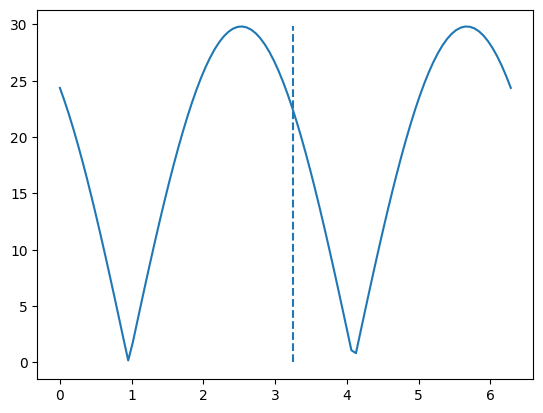

In [15]:
plt.plot(test_phis, res_SNRs)
plt.vlines(MBHB_params["coalescence_phase"], 0, np.max(res_SNRs), linestyle="--")
min(res_SNRs)

In [16]:
bestfit_params = MBHB_params.copy() 
bestfit_params["coalescence_phase"] = test_phis[np.argmin(res_SNRs)]
X2_bestfit, _, _ = mbhb_mich_generator(parameters=bestfit_params, waveform_generator=mbhb_waveform_generator, optimal_combination=False, complex_waveform=True)

(13.8, 14.22)

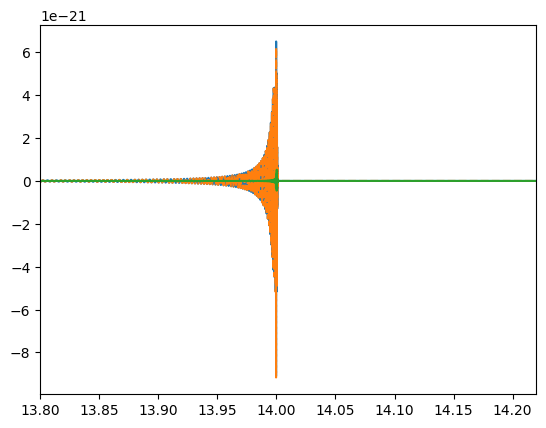

In [17]:
plt.plot(tcb_times_slice/DAY, X2_general)
plt.plot(tcb_times_slice/DAY, X2_bestfit, linestyle="--")
plt.plot(tcb_times_slice/DAY, X2_general - X2_bestfit)
# plt.xlim(MBHB_params["coalescence_time"] + 0.01, MBHB_params["coalescence_time"] + 0.03)
# plt.ylim(-1e-22, 1e-22)
plt.xlim(13.8, 14.22)

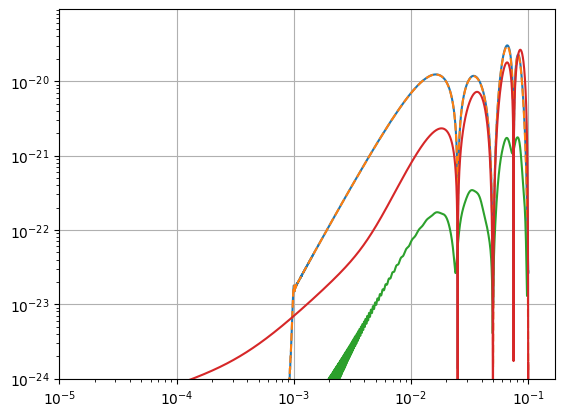

In [18]:
ff, xf = FFT_window(X2_general, 1./dt, "tukey", dict(alpha=0.05))
plt.loglog(ff, np.abs(xf) * 2. * ff)

_, xf1 = FFT_window(X2_bestfit, 1./dt, "tukey", dict(alpha=0.05))
plt.loglog(ff, np.abs(xf1) * 2. * ff, linestyle="--")

plt.loglog(ff, np.abs(xf - xf1) * 2. * ff)

PSDfunc = TDIPSDs() 
plt.loglog(ff, np.sqrt(PSDfunc.PSD_X2(ff) * ff))
plt.ylim(1e-24,)
plt.xlim(1e-5,)
plt.grid()

## Test on GB 

In [12]:
Tobs = YEAR 
dt = 10. 
tcb_times = np.arange(int(Tobs / dt)) * dt 

gb_waveform_generator = GB_Injection(use_gpu=False)

gb_general_response_generator = GeneralTDIResponse(
    orbit=orbit, 
    Pstring=GeneralTDIResponse.X2_strings, 
    tcb_times=tcb_times.copy(), 
    use_gpu=False, 
    drop_points=int(1000./dt), 
    linear_interp=False, 
    return_eta=False, 
)

In [13]:
GB_params = {"A": 1.52072235e-22, "f0": 0.00261367, "fdot0": 3.34732748e-17, "phase0": 3.42918555, "inclination": 1.5166699, "longitude": 1.7686, "latitude": 0.10127302, "psi": 0.94753924}
GB_params

{'A': 1.52072235e-22,
 'f0': 0.00261367,
 'fdot0': 3.34732748e-17,
 'phase0': 3.42918555,
 'inclination': 1.5166699,
 'longitude': 1.7686,
 'latitude': 0.10127302,
 'psi': 0.94753924}

In [14]:
for _ in tqdm(range(10)):
    X2_gb_general = gb_general_response_generator(parameters=GB_params, waveform_generator=gb_waveform_generator)
X2_gb_general.shape

100%|██████████| 10/10 [02:02<00:00, 12.22s/it]


(3155814,)

In [15]:
gb_waveform_generator_gpu = GB_Injection(use_gpu=True)

gb_mich_response_generator = FastMichelsonTDIResponse(
    orbit=orbit, 
    tcb_times=xp.array(tcb_times), 
    use_gpu=True, 
    drop_points=int(1000./dt), 
    interp_method="linear",
)

In [16]:
for _ in tqdm(range(10)):
    X2_gb_mich, _, _ = gb_mich_response_generator(parameters=GB_params, waveform_generator=gb_waveform_generator_gpu, optimal_combination=False)
X2_gb_mich.shape

100%|██████████| 10/10 [00:01<00:00,  5.39it/s]


(3155814,)

In [17]:
X2_gb_mich = X2_gb_mich.get()

(0.0, 0.1)

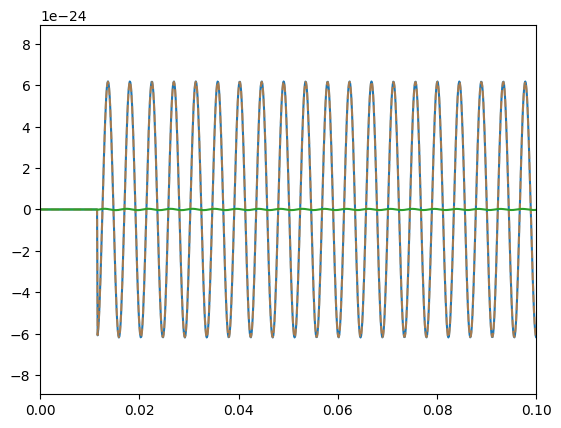

In [18]:
plt.plot(tcb_times/DAY, X2_gb_general)
plt.plot(tcb_times/DAY, X2_gb_mich, linestyle="--", alpha=0.6)
plt.plot(tcb_times/DAY, X2_gb_general - X2_gb_mich)
plt.xlim(0, 0.1)

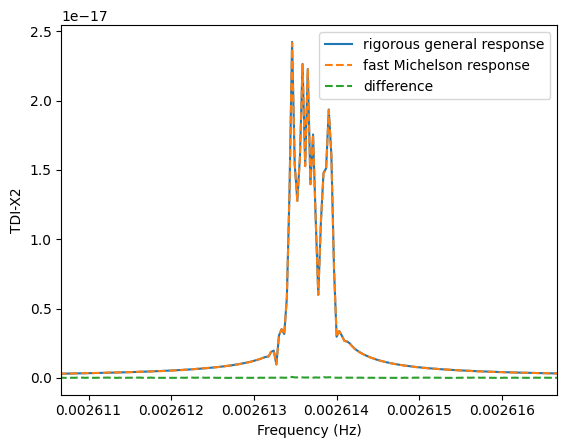

In [19]:
ff, xf = FFT_window(X2_gb_general, 1./dt)
plt.plot(ff, np.abs(xf), label="rigorous general response")

ff, xf1 = FFT_window(X2_gb_mich, 1./dt)
plt.plot(ff, np.abs(xf1), linestyle="--", label="fast Michelson response")

plt.plot(ff, np.abs(xf1 - xf), linestyle="--", label="difference")

plt.xlim(GB_params["f0"] - 0.3e-5, GB_params["f0"] + 0.3e-5)
plt.xlabel("Frequency (Hz)")
plt.ylabel("TDI-X2")
plt.legend(loc="upper right")

## Test emri waveform